<a href="https://colab.research.google.com/github/jafetmorales/indoor-locationing/blob/master/Copy_of_wifi_locationing_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary

**Datasets**:    UJIIndoorLoc_trainingData.csv (training/validation set), UNJIndoorLoc_validationData.csv (test set)

**Scenario**:    Determine the feasbility of using Wi-Fi fingerprints indoor smartphone locationing.
             
**Goal**:        Benchmark 3 indoor locationing solutions using the UJIIndoorLoc dataset from http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc. In this script, we'll use a knn classifier.
             
**Conclusion**:  Please read my "Evaluate Techniques for Wi-Fi Locationing" technical report for full details of methodology and conclusions.
             
- Tuned knn: "KNeighborsClassifier_model.sav"
  - metric: manhattan
  - n_neighbors: 1
  
             
- Tuning insights: See "tuning_knn.csv" for results of all hyperparameter combinations tried. A 1NN with the manhattan distance performed best on the validation set.
             
             
- Reason: gives good cross-validation scores. There’s some overfitting, suggested by the 14% gap between the cross-validation score and the average training set score across the folds.

             
- Training set performance (average of k-folds): accuracy 0.966 kappa 0.966  

             
- Cross validation performance: accuracy 0.818 kappa 0.818

  
- Test set performance: 

  - mean positional error 12.394 m
  - 25th percentile       1.875 m
  - 50th percentile       6.017 m
  - 75th percentile       12.342 m
  - 95th percentile       37.355 m
  - 100th percentile      369.158 m
  - Building hitrate      98.6%
  - Floor hitrate         88.0%

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import math
import pickle

from google.colab import drive
drive.mount('/content/drive')

# Import Data

In [0]:
# training/validation set
train_set = pd.read_csv("/content/drive/My Drive/Colab Notebooks/UJIIndoorLoc_trainingData.csv")

# test set
test_set = pd.read_csv("/content/drive/My Drive/Colab Notebooks/UJIIndoorLoc_validationData.csv")
# test_set = pd.read_csv("UJIIndoorLoc_validationData.csv")

# Evaluate Data

Training/validation Set

In [0]:
train_set.loc[train_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors


In [0]:
train_set.loc[train_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

In [0]:
train_set.loc[train_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

In [0]:
train_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

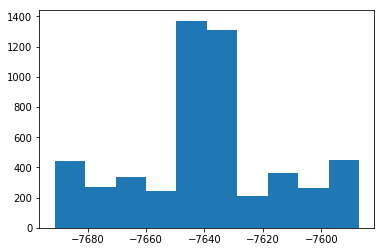

In [0]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()
# Almost all fingerprints were collected right outside the door to each 
# fingerprint's SPACEID location.
# Building 0 fingerprints were collected by just 2 devices (and 2 separate 
# users). Not a lot of variety in different devices.

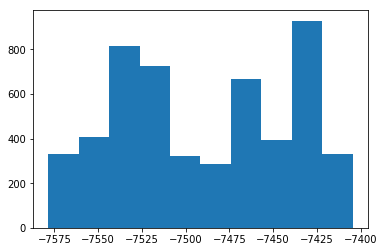

In [0]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

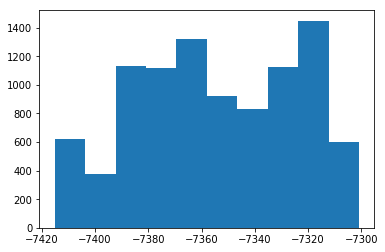

In [0]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

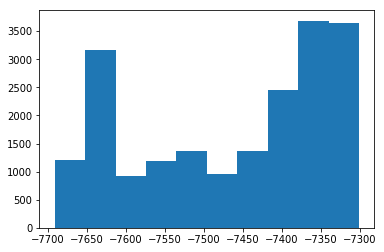

In [0]:
plt.hist(train_set["LONGITUDE"])
plt.show()
# Most fingerprints were collected right outside the door to each fingerprint's
# SPACEID location.

In [0]:
# check for missing values
pd.isnull(train_set)
pd.isnull(train_set).values.any()
# No missing values 

False

Test Set

In [0]:
test_set.loc[test_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors

array([2, 1, 0, 3])

In [0]:
test_set.loc[test_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

array([1, 3, 2, 0])

In [0]:
test_set.loc[test_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

array([4, 2, 3, 0, 1])

In [0]:
test_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

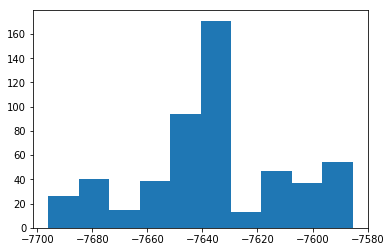

In [0]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

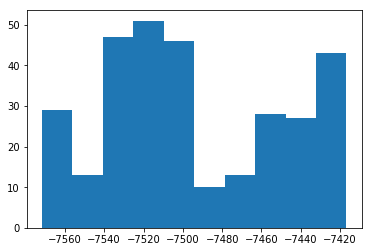

In [0]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

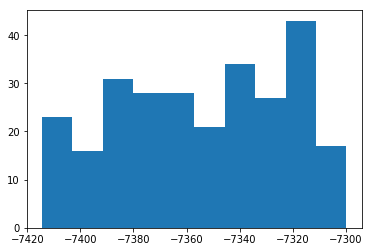

In [0]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

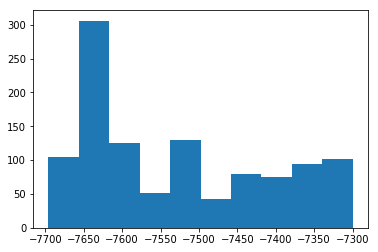

In [0]:
plt.hist(test_set["LONGITUDE"])
plt.show()

In [0]:
# check for missing values
pd.isnull(test_set)
pd.isnull(test_set).values.any()
# No missing values

False

# Preprocess Data and Feature Engineering

Training/validation Set

In [0]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
train_set.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P = train_set.copy()
train_set_P.iloc[:, 0:520] = np.where(train_set_P.iloc[:, 0:520] <= 0, 
                train_set_P.iloc[:, 0:520] + 105, 
                train_set_P.iloc[:, 0:520] - 100) 

In [0]:
# Feature Scaling - do not center - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

In [0]:
# Create a single label for the model to predict. FLOOR, LATITUDE, FLOOR, and 
# BUILDINGID pinpoints the exact location of a user inside a building. Stack 
# train set and test set first before assigning unique location so that 
# identical locations are assigned the same UNIQUELOCATION value.
combined = pd.concat([train_set_P, test_set]) # stack vertically
combined = combined.assign(UNIQUELOCATION = (combined['LONGITUDE'].astype(str) + '_' + combined['LATITUDE'].astype(str) + '_' + combined['FLOOR'].astype(str) + '_' + combined['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined["UNIQUELOCATION"].unique()) # 1995 unique locations

1995

In [0]:
# split again
train_set_PU = combined.iloc[0:19937, :]
test_set_U = combined.iloc[19937:21048, :]

In [0]:
# Change variable types
train_set_PU["UNIQUELOCATION"] = train_set_PU["UNIQUELOCATION"].astype("category")
train_set_PU.dtypes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
WAP006                 int64
WAP007                 int64
WAP008                 int64
WAP009                 int64
WAP010                 int64
WAP011                 int64
WAP012                 int64
WAP013                 int64
WAP014                 int64
WAP015                 int64
WAP016                 int64
WAP017                 int64
WAP018                 int64
WAP019                 int64
WAP020                 int64
WAP021                 int64
WAP022                 int64
WAP023                 int64
WAP024                 int64
WAP025                 int64
WAP026                 int64
WAP027                 int64
WAP028                 int64
WAP029                 int64
WAP030                 int64
                      ...   
WAP501                 int64
WAP502                 int64
WAP503                 int64
WAP504        

In [0]:
X_train = train_set_PU.iloc[:, 0:520]
y_train = train_set_PU.iloc[:, 520:530]

Test Set

In [0]:
# Fingerprint data representation
test_set_PU = test_set_U.copy()
test_set_PU.iloc[:, 0:520] = np.where(test_set_PU.iloc[:, 0:520] <= 0, test_set_PU.iloc[:, 0:520] + 105, test_set_PU.iloc[:, 0:520] - 100) 

In [0]:
# Feature Scaling - do not center this data - destroys sparse structure of
# this data. There's also no need to normalize the WAPs, since they're all on
# the same scale already.

In [0]:
test_set_PU["UNIQUELOCATION"] = test_set_PU["UNIQUELOCATION"].astype("category")
test_set_PU.dtypes

WAP001                 int64
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
WAP006                 int64
WAP007                 int64
WAP008                 int64
WAP009                 int64
WAP010                 int64
WAP011                 int64
WAP012                 int64
WAP013                 int64
WAP014                 int64
WAP015                 int64
WAP016                 int64
WAP017                 int64
WAP018                 int64
WAP019                 int64
WAP020                 int64
WAP021                 int64
WAP022                 int64
WAP023                 int64
WAP024                 int64
WAP025                 int64
WAP026                 int64
WAP027                 int64
WAP028                 int64
WAP029                 int64
WAP030                 int64
                      ...   
WAP501                 int64
WAP502                 int64
WAP503                 int64
WAP504        

In [0]:
X_test = test_set_PU.iloc[:, 0:520]
y_test = test_set_PU.iloc[:, 520:530]

In [0]:
# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table = pd.concat([y_train.iloc[:, [0,1,2,3,9]], y_test.iloc[:, [0,1,2,3,9]]])
ref_table = ref_table.drop_duplicates()

In [0]:
#--- save data ---#
def save_data(dataframe, filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:
        dataframe.to_csv(filename)
    else:
        print('WARNING: This file already exists.')

In [0]:
#save_data(X_train, 'X_train_knn.csv')
#save_data(y_train, 'y_train_knn.csv')
#save_data(X_test, 'X_test_knn.csv')
#save_data(y_test, 'y_test_knn.csv')

In [0]:
#--- load data ---#
#X_train = pd.read_csv('X_train_knn.csv', index_col = 0)
#y_train = pd.read_csv('y_train_knn.csv', index_col = 0)
#X_test = pd.read_csv('X_test_knn.csv', index_col = 0)
#y_test = pd.read_csv('y_test_knn.csv', index_col = 0)

In [0]:
#-- delete unneeded datasets created during preprocessing to free up memory --#
del train_set, train_set_P, train_set_PU, test_set, test_set_U, test_set_PU, combined

# Train Model(s)

KNN

In [0]:
# Using cross-validation, train best random forest model to predict 
# UNIQUELOCATION. We report the accuracy and kappa on UNIQUELOCATION predictions
# for cross-validation and on the training set. We report location error metrics
# on the test set.

# Using cross-validation, train best k-nn model for predicting UNIQUELOCATION.
# For cross-validation and training set performance metrics, we will simply use 
# the accuracy and kappa of predicting UNIQUELOCATION values. We will evaluate
# the test set performance using a method defined.


if __name__ == '__main__':
    
    # Select model
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier()
    
    # 'parameters' can be a list of dictionaries for more specificity in 
    # hyperparamter combinations to attempt.
    # hyperparameters: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    # for a list of hyperparameters tried, see "tuning_knn.csv"
    hyperparameters = {'n_neighbors': [1],
                       'metric': ['manhattan']}
   
    
    # Apply k-fold cross-validation with grid search
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier,
                        param_grid = hyperparameters,
                        scoring = scoring,
                        cv = 10,
                        refit = 'accuracy', # what best model is based on, and specifies that the best model will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) # squeeze() makes sure y_train is a Series, as recommended now and required in upcoming sklearn versions.
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [0]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['KNeighborsClassifier']*cv_results_.shape[0])
cv_results_.insert(loc = 58, column = 'mean train - cross_val accuracy', 
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 59, column = 'mean train - cross_val kappa', 
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_knn.csv', 'a') as f:
    cv_results_.to_csv(f, header = False, index = False)

In [0]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [0]:
#--- save best model ---#

def save_model(model, model_name):
    model_name_present = glob.glob(model_name) # boolean, same model name already present?
    if not model_name_present:
        pickle.dump(grid_result, open(model_name, 'wb'))
    else:
        print('WARNING: This file already exists.')

In [0]:
#save_model(grid_result, 'KNeighborsClassifier_model.sav')

In [0]:
#--- load model ---#
grid_result = pickle.load(open('KNeighborsClassifier_model.sav', 'rb'))

In [0]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])
# Prediction accuracy on UNIQUELOCATION for the test set is very low because 
# each UNIQUELOCATION value depends on the LONGTITUDE, LATITUDE, FLOOR, and
# BUILDINGID, making the values quite unique. UJIIndoorLoc_validation.csv 
# (from which the test set came from) contains examples taken by users and 
# phones that did not participate in generating UJIIndoorLoc_train.csv 
# (training set). That alone may cause the Wi-Fi fingerprint-to-UNIQUELOCATION 
# mapping quite difficult to capture. However, since what we're really 
# interested in is how close our predicted positions are to the ground truth, 
# let's convert the predicted UNIQUELOCATIONS on the test set back to its
# associated LONGITUDE, LATITUDE, FLOOR, and BUILDINGID. Then, report the 
# following metrics for position predictions: Euclidean distances between the 
# predicted and ground truth positions. Mean positional error and the 25th, 50th, 75th, 
# 95th, 100th (worst) percentiles of the positional errors. The hitrate for 
# BUILDINGID and FLOOR.

In [0]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [0]:
def euclidean(y_test_pos, y_pred_pos):
    """
    Returns the prediction errors based on euclidean distances for each test 
    example. The prediction error for each test set example is the euclidean 
    distance between the test set's position (ground truth) and the predicted 
    position. A "position" is a pair of LONGITUDE and LATITUDE values, 
    e.g. -7515.92, 4.86489e+06.
    
    Arguments:
    y_test_pos -- test set positions represented by numpy array of shape 
                  (m_test, 2)
    y_pred_pos -- predicted test set position represented by numpy array of shape
                  (m_test, 2)
    
    Returns:
    D_error -- prediction errors between test set positions and predicted test 
               set positions represented by numpy array of shape (m_train, 1)
    """
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [0]:
D_error = euclidean(y_test_pos, y_pred_pos) # position errors for each test set example, in order as they appear 
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) # meters
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)